In [1]:
import numpy as np
from matplotlib import pyplot as plt

data = np.load('sdss_galaxy_colors.npy')

features = np.asarray([data['u']-data['g'],\
                       data['g']-data['i'],\
                       data['r']-data['i'],\
                       data['i']-data['z'] ])
features = features.T

targets = np.asarray(data['redshift'])

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

train_features, test_features, train_targets, test_targets = train_test_split(features, targets, random_state=60, test_size=0.5)

d_tree = DecisionTreeRegressor()
d_tree.fit(train_features, train_targets)

predictions_d_tree = d_tree.predict(test_features)
eval_d_tree = np.median(np.abs(predictions_d_tree - test_targets))
eval_d_tree

0.021998945

# 25. El problema del sobre-ajuste de los Árboles de Decisión.

In [3]:
dec_tree = DecisionTreeRegressor(max_depth=5)
dec_tree.fit(train_features, train_targets)

predictions = dec_tree.predict(test_features)
eval_dec_tree = np.median(np.abs(predictions - test_targets))
eval_dec_tree

0.03683017499999999

$\textbf{Defina una función que cree el árbol de decisión con profundidades en el rango de 0 a 40.}$

$\textbf{Grafique la mediana de los residuos vs profundidad del árbol.}$

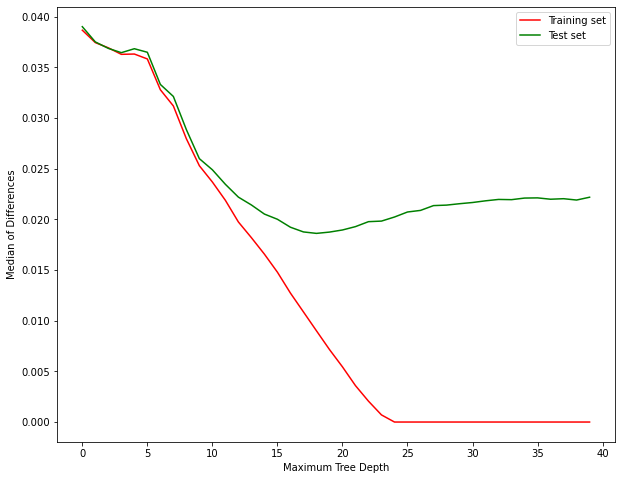

In [4]:
def depth(train_features, train_targets, test_features, test_targets):
    dec_tree=np.zeros(41,dtype=object)
    eval_dec_tree_test=np.zeros(41)
    eval_dec_tree_train=np.zeros(41)
    predictions_test=np.zeros(41,dtype=object)
    predictions_train=np.zeros(41,dtype=object)
    for i in range(1,41):
        dec_tree[i-1] = DecisionTreeRegressor(max_depth=i)
        dec_tree[i-1].fit(train_features, train_targets)

        predictions_test[i-1] = dec_tree[i-1].predict(test_features)
        predictions_train[i-1] = dec_tree[i-1].predict(train_features)
        eval_dec_tree_test[i-1] = np.median(np.abs(predictions_test[i-1] - test_targets))
        eval_dec_tree_train[i-1] = np.median(np.abs(predictions_train[i-1] - train_targets))
    return eval_dec_tree_test, eval_dec_tree_train
        
median=depth(train_features, train_targets, test_features, test_targets)
median_train=median[1]
median_test=median[0]

fig1 = plt.figure(figsize=(10,8))
ax1 = plt.subplot()
ax1.plot(range(0,40), median_train[0:40], color='red', label='Training set')
ax1.plot(range(0,40), median_test[0:40], color='green', label='Test set')
ax1.set_ylabel('Median of Differences')
ax1.set_xlabel('Maximum Tree Depth')
plt.legend()
plt.show()

# 26. Validación cruzada del Árbol de Decisión

In [5]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)
dec_tree = DecisionTreeRegressor(max_depth=19)

all_predictions = np.zeros_like(targets)

for train_indices, test_indices in kf.split(features):
    train_features, test_features = features[train_indices], features[test_indices]
    train_targets, test_targets = targets[train_indices], targets[test_indices]

    dec_tree.fit(train_features, train_targets)

    predictions = dec_tree.predict(test_features)

    all_predictions[test_indices] = predictions

eval_dec_tree = np.median(np.abs(all_predictions - targets))
eval_dec_tree

0.018043957645556025

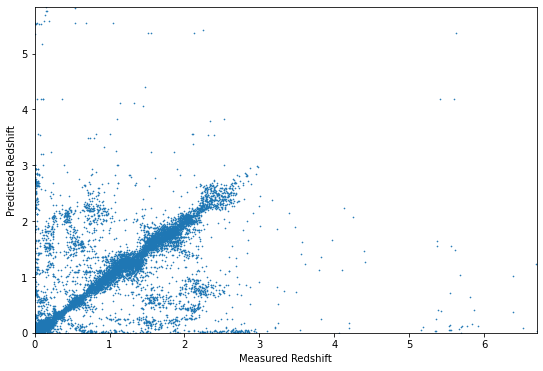

In [12]:
plt.figure(figsize=(9,6))
plt.scatter(targets, all_predictions, s=0.4)
plt.xlim((0, targets.max()))
plt.ylim((0, predictions.max()))
plt.xlabel('Measured Redshift')
plt.ylabel('Predicted Redshift')
plt.show()

$\textbf{Clasificación de las muestras de acuerdo con el 'spec_class'. Cuantas galaxias y cuantos QSOs existen en el archivo?}$

In [7]:
n=0
for i in range(data.size):
    if data[i]['spec_class'] == b'GALAXY':
        n=n+1

qso = [None]*(data.size-n)
galaxy = [None]*n
a = 0
b = 0
for i in range(data.size):
    if data[i]['spec_class'] == b'GALAXY':
        galaxy[a] = i
        a = a+1
    else:
        qso[b] = i
        b = b+1
            
len(galaxy), len(qso)   # Números de galaxias y QSOs respectivamente.

(41475, 8525)

$\textbf{Mediana de los residuos para galaxias y QSOs. Cuáles son los valores máximos de estas diferencias para los dos tipos de objetos?}$

In [8]:
all_predictions_qso = np.zeros(len(qso))
all_predictions_galaxy = np.zeros(len(galaxy))
targets_qso = np.zeros(len(qso))
targets_galaxy = np.zeros(len(galaxy))

for i in range(len(qso)):
    all_predictions_qso[i] = all_predictions[qso[i]]
    targets_qso[i] = targets[qso[i]]
    
for i in range(len(galaxy)):
    all_predictions_galaxy[i] = all_predictions[galaxy[i]]
    targets_galaxy[i] = targets[galaxy[i]]

eval_dec_tree_galaxy = np.median(np.abs(all_predictions_galaxy - targets_galaxy))
eval_dec_tree_qso = np.median(np.abs(all_predictions_qso - targets_qso))

eval_dec_tree_galaxy, eval_dec_tree_qso   # Mediana para las galaxias y para QSOs respectivamente

(0.015199739755719463, 0.08070761538461646)

In [9]:
dif_galaxy = np.abs(all_predictions_galaxy - targets_galaxy)
dif_qso = np.abs(all_predictions_qso - targets_qso)

dif_galaxy[np.argmax(dif_galaxy)], dif_qso[np.argmax(dif_qso)]    # Valores máximos de diferencias para galaxias y QSOs.

(6.47794537, 6.66654064)

$\textbf{Gráfico con la mediana de los residuos vs. Redshift medido}$

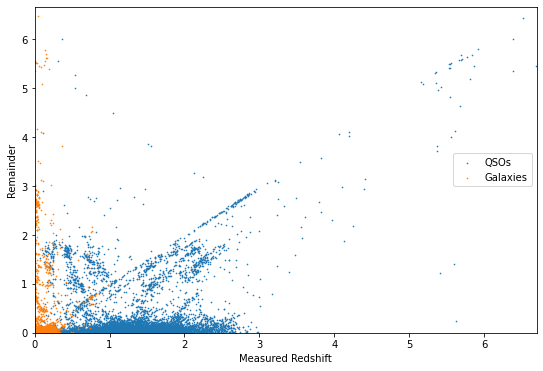

In [17]:
plt.figure(figsize=(9,6))
plt.scatter(targets_qso, dif_qso, s=0.4, label='QSOs')
plt.scatter(targets_galaxy, dif_galaxy, s=0.4, label='Galaxies')
plt.xlim((0, targets.max()))
plt.ylim((0, dif_qso.max()))
plt.xlabel('Measured Redshift')
plt.ylabel('Remainder')
plt.legend()
plt.show()

$\textbf{Gráfico con las predicciones vs mediciones de corrimiento al rojo}$

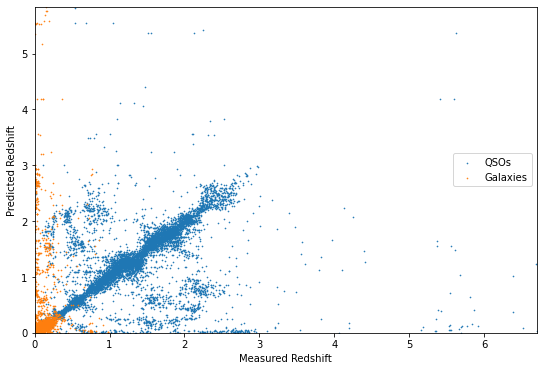

In [10]:
plt.figure(figsize=(9,6))
plt.scatter(targets_qso, all_predictions_qso, s=0.4, label='QSOs')
plt.scatter(targets_galaxy, all_predictions_galaxy, s=0.4, label='Galaxies')
plt.xlim((0, targets.max()))
plt.ylim((0, predictions.max()))
plt.xlabel('Measured Redshift')
plt.ylabel('Predicted Redshift')
plt.legend()
plt.show()